In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.array import Array
from custom_jax_sim import DynamicsBackendEstimator, JaxSolver
from qiskit import transpile, pulse
from qiskit.compiler import schedule as build_schedule
import numpy as np
from qiskit.quantum_info import Statevector, Operator
from helper_functions import perform_standard_calibrations
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
# Define the system
dim = 3

v0, v1 = 4.86e9, 4.97e9
anharm0, anharm1 = -0.32e9, -0.32e9
r0, r1 = 0.22e9, 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0, N1 = np.kron(ident, N), np.kron(N, ident)
a0, a1 = np.kron(ident, a), np.kron(a, ident)
a0dag, a1dag = np.kron(ident, adag), np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = (
    static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))
)

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1 / 4.5e9

solver_2q_jax = JaxSolver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)
solver_2q = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)
# Consistent solver option to use throughout notebook

solver_options = [
    {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt} for _ in range(2)
]
solver = solver_2q_jax
jax_backend = DynamicsBackend(
    solver=solver_2q_jax,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options[0],  # to be used every time run is called
)

standard_backend = DynamicsBackend(
    solver=solver_2q,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options[1],  # to be used every time run is called
)

In [3]:
jax_cals, jax_results = perform_standard_calibrations(backend=jax_backend)
standard_cals, standard_results = perform_standard_calibrations(
    backend=standard_backend
)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'s', 'h', 'reset', 'tdg', 'rz', 'x', 'sdg', 't', 'delay', 'id', 'measure', 'z', 'sx'}
  q1: {'s', 'h', 'reset', 'tdg', 'rz', 'x', 'sdg', 't', 'delay', 'id', 'measure', 'z', 'sx'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'cr45m', 'ecr'}
  (1, 0): {'cr45p', 'cr45m', 'ecr'}
)>
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done fo

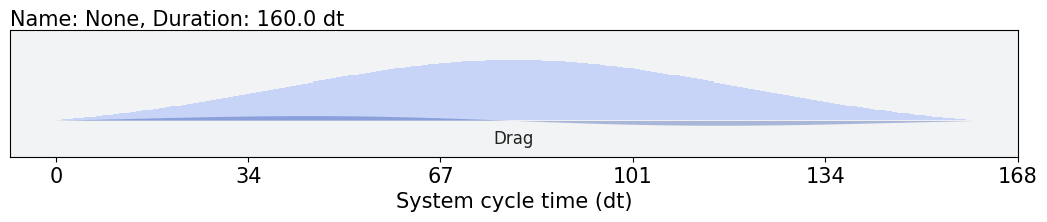

In [4]:
x_amp_ref = jax_backend.target.get_calibration("sx", (0,)).instructions[0][1].pulse.amp
jax_backend.target.get_calibration("x", (0,)).instructions[0][1].pulse.draw()

In [71]:
# use amplitude as the function argument
from qiskit import pulse
from qiskit_dynamics.pulse import InstructionToSignals
import sympy as sym
from qiskit_dynamics.array import wrap

jit = wrap(jax.jit, decorator=True)
qd_vmap = wrap(jax.vmap, decorator=True)
qc = QuantumCircuit(1)
param = Parameter("amp")
qc.x(0)


def jit_func(amp):
    drag_pulse = pulse.Drag(duration=160, amp=amp, sigma=40, angle=0, beta=6.6166741255)

    # build a pulse schedule
    with pulse.build(backend=jax_backend) as schedule:
        pulse.call(qc)
        # pulse.play(gaussian_pulse, pulse.DriveChannel(0))
        # pulse.play(drag_pulse, pulse.DriveChannel(0))
    # convert from a pulse schedule to a list of signals

    results = solver_2q_jax.solve(
        t_span=Array([0, 300 * dt]),
        y0=jnp.eye(9),
        signals=schedule,
        **solver_options[0]
    )
    return Array(results.t).data, Array(results.y).data


sim_func = jax.jit(jit_func)
results = sim_func(x_amp_ref)

In [72]:
Statevector.from_int(0, 9).evolve(Operator(np.array(results[1][1])))

Statevector([ 8.72954826e-03+1.54193266e-01j,
             -5.03329666e-02-9.86599825e-01j,
             -7.73289019e-04-6.29440128e-04j,
              8.51469150e-04+1.77025711e-02j,
              6.78290605e-05-2.96518665e-05j,
              1.49296195e-05+2.93749759e-04j,
              7.08539834e-07-6.17958609e-07j,
             -1.79411910e-07-2.65508474e-06j,
              1.75028853e-08+1.16030827e-08j],
            dims=(9,))


In [73]:
from helper_functions import projected_statevector, qubit_projection

print(
    projected_statevector(
        Statevector.from_int(0, 9).evolve(Operator(np.array(results[1][1]))).data,
        [3, 3],
    )
)
qubit_projection(np.array(results[1][1]), [3, 3])

Statevector([ 8.72954826e-03+1.54193266e-01j,
             -5.03329666e-02-9.86599825e-01j,
              8.51469150e-04+1.77025711e-02j,
              6.78290605e-05-2.96518665e-05j],
            dims=(2, 2))
Operator([[ 8.72954826e-03+1.54193266e-01j,
           -4.21461640e-02-9.86984854e-01j,
            7.26887433e-04+1.76866252e-02j,
            2.62961263e-05-4.72886940e-06j],
          [-5.03329666e-02-9.86599825e-01j,
           -5.69539776e-03-1.54235503e-01j,
            3.38659697e-04+5.60381631e-03j,
           -9.02488236e-04-1.76799842e-02j],
          [ 8.51469150e-04+1.77025711e-02j,
            3.01086821e-04+5.57927791e-03j,
            9.32680893e-03+1.56696574e-01j,
           -4.84570281e-02-9.86164085e-01j],
          [ 6.78290605e-05-2.96518665e-05j,
           -8.01955250e-04-1.76853299e-02j,
           -4.41628250e-02-9.86364723e-01j,
           -5.32825184e-03-1.56915130e-01j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [76]:
from qiskit.quantum_info import state_fidelity, average_gate_fidelity
from qiskit.circuit.library import HGate

print(
    state_fidelity(
        projected_statevector(
            Statevector.from_int(1, 9).evolve(Operator(np.array(results[1][1]))).data,
            [3, 3],
        ),
        Statevector.from_label("00"),
        validate=False,
    )
)

gate_fid = average_gate_fidelity(
    qubit_projection(np.array(results[1][1]), [3, 3]), Operator.from_label("IH")
)
gate_fid

0.9759154019404318


0.4768450831707124

In [85]:
s1 = Statevector.from_int(0, 3)
s2 = Statevector.from_int(0, 3)
s = s1.tensor(s2)
print(s)
state_fidelity(
    projected_statevector(
        s.evolve(
            Operator(np.array(results[1][1]), input_dims=(3, 3), output_dims=(3, 3))
        ).data,
        [3, 3],
    ),
    Statevector.from_label("01"),
    validate=False,
)

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(3, 3))


0.975912621757285

In [77]:
average_gate_fidelity(Operator.from_label("I"), Operator.from_label("Z"))

0.3333333333333333

In [68]:
Operator.from_label("IH")

Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
            0.70710678+0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
           -0.70710678+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
